In [1]:
import numpy as np
import pandas as pd
rng = np.random.default_rng()

from matplotlib import pyplot as plt

In [2]:
city_list = ['Los Angeles', 'New York', 'San Francisco', 'Las Vegas', 'Raleigh', 'Tucson', 'Phoenix', 'Columbus']
year_list = np.arange(2008, 2023)
x_list = ['population', 'avg_hh_income', 'tourists']
y_list = ['airbnb_listings', 'building_permits']
treat_year = 2016


In [3]:
# Base values for all variables

base = {}
base['Los Angeles'] = {
    'x': {
        'population': 3800000,
        'avg_hh_income': 80000,
        'tourists': 1200000
    },
    'y': {
        'airbnb_listings': 30000,
        'building_permits': 40000
    }
}
base['New York'] = {
    'x': {
        'population': 19000000,
        'avg_hh_income': 95000,
        'tourists': 6000000
    },
    'y': {
        'airbnb_listings': 70000,
        'building_permits': 50000
    }
}
base['San Francisco'] = {
    'x': {
        'population': 800000,
        'avg_hh_income': 90000,
        'tourists': 500000
    },
    'y': {
        'airbnb_listings': 20000,
        'building_permits': 15000
    }
}
base['Las Vegas'] = {
    'x': {
        'population': 500000,
        'avg_hh_income': 45000,
        'tourists': 400000
    },
    'y': {
        'airbnb_listings': 40000,
        'building_permits': 7000
    }
}
base['Raleigh'] = {
    'x': {
        'population': 400000,
        'avg_hh_income': 60000,
        'tourists': 100000
    },
    'y': {
        'airbnb_listings': 4000,
        'building_permits': 10000
    }
}
base['Tucson'] = {
    'x': {
        'population': 500000,
        'avg_hh_income': 50000,
        'tourists': 100000
    },
    'y': {
        'airbnb_listings': 5000,
        'building_permits': 17000
    }
}
base['Phoenix'] = {
    'x': {
        'population': 1500000,
        'avg_hh_income': 55000,
        'tourists': 400000
    },
    'y': {
        'airbnb_listings': 15000,
        'building_permits': 20000
    }
}
base['Columbus'] = {
    'x': {
        'population': 700000,
        'avg_hh_income': 40000,
        'tourists': 80000
    },
    'y': {
        'airbnb_listings': 2000,
        'building_permits': 13000
    }
}

assert len(set(city_list).difference(set(base.keys())))==0
for city in city_list:
    assert len(set(x_list).difference(set(base[city]['x'].keys())))==0
    assert len(set(y_list).difference(set(base[city]['y'].keys())))==0

In [4]:
# Year fixed effects

year_fe = {}

for year in year_list:
    year_fe[year] = {
        'airbnb_listings': (min(year,treat_year)-2008)*0.02, 
        'building_permits': 0
    }


In [5]:
# x variable transitions

trans_x = {
    'population': {
        'growth': 0.02,
        'sd': 0.01
    },
    'avg_hh_income': {
        'growth': 0.025,
        'sd': 0.025
    },
    'tourists': {
        'growth': 0.01,
        'sd': 0.03
    }
}

assert len(set(x_list).difference(set(trans_x.keys())))==0


In [6]:
# coefficients and residuals

coefs = {
    'airbnb_listings': {
        'population': 0.08,
        'avg_hh_income': 0.13,
        'tourists': 0.24,
        'sd': 0.03
    },
    'building_permits': {
        'population': 0.17,
        'avg_hh_income': 0.05,
        'tourists': 0.0,
        'sd': 0.02
    }
}
    
assert len(set(y_list).difference(set(coefs.keys())))==0
for y in y_list:
    assert len(set(x_list).difference(set(coefs[y].keys())))==0



In [7]:
# treatment effects

ate = {
    'airbnb_listings': -0.27,
    'building_permits': -0.11
}

treated = {
    'Los Angeles': 1,
    'New York': 1,
    'San Francisco': 1,
    'Las Vegas': 1,
    'Raleigh': 0,
    'Tucson': 0,
    'Phoenix': 0,
    'Columbus': 0
}

assert len(set(y_list).difference(set(ate.keys())))==0
assert len(set(city_list).difference(set(treated.keys())))==0


In [8]:
df = []

for city in city_list:
    
    curr_x = {}
    for x in x_list:
        curr_x[x] = base[city]['x'][x]
    
    for year in year_list:
        row = {'city': city, 'year': year}
        
        # Update x vars
        for x in x_list:
            curr_x[x] = np.exp( np.log(curr_x[x]) + trans_x[x]['growth'] + rng.normal(loc=0, scale=trans_x[x]['sd']) )
            row[x] = np.round( curr_x[x] )
        
        # Update y vars
        for y in y_list:
            logy = np.log(base[city]['y'][y]) + year_fe[year][y] + (year>=treat_year)*treated[city]*ate[y] + rng.normal(loc=0, scale=coefs[y]['sd'])
            for x in x_list:
                logy += coefs[y][x]*(np.log(curr_x[x]) - np.log(base[city]['x'][x]))
            row[y] = np.round( np.exp(logy) )
        
        df.append(row)
        
df = pd.DataFrame(df)

df

,city,year,population,avg_hh_income,tourists,airbnb_listings,building_permits
0,Los Angeles,2008,3808149.0,79260.0,1207225.0,30281.0,39082.0
1,Los Angeles,2009,3902735.0,81901.0,1287159.0,32433.0,41310.0
2,Los Angeles,2010,3996799.0,84904.0,1358208.0,31865.0,40066.0
3,Los Angeles,2011,4113113.0,88501.0,1376293.0,33599.0,40934.0
4,Los Angeles,2012,4219294.0,94636.0,1446586.0,34532.0,41727.0
...,...,...,...,...,...,...,...
115,Columbus,2018,892461.0,50006.0,86423.0,2563.0,13732.0
116,Columbus,2019,912520.0,48220.0,86053.0,2472.0,13194.0
117,Columbus,2020,930572.0,51657.0,91828.0,2513.0,13685.0
118,Columbus,2021,938189.0,52791.0,89587.0,2505.0,13841.0


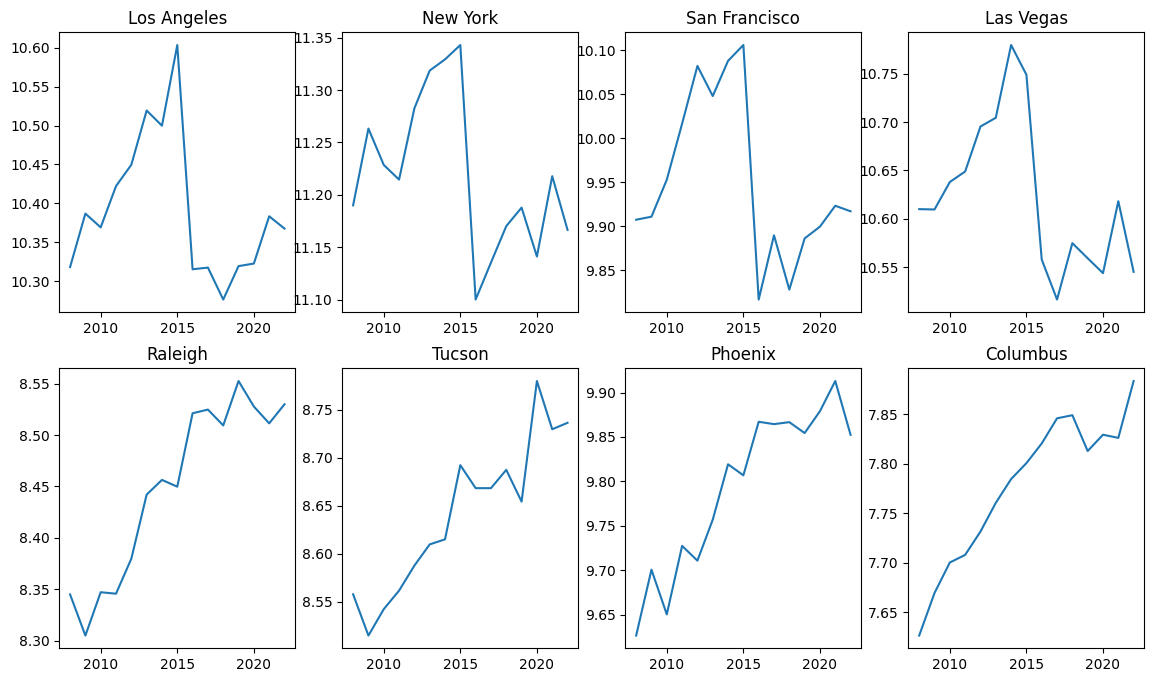

In [9]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
for i, ax in enumerate(axs.flat):
    if i<len(city_list):
        city = city_list[i]
        x = df.loc[ df['city']==city, 'year']
        y = np.log(df.loc[ df['city']==city, 'airbnb_listings'])
        ax.plot(x, y)
        ax.set_title(city)


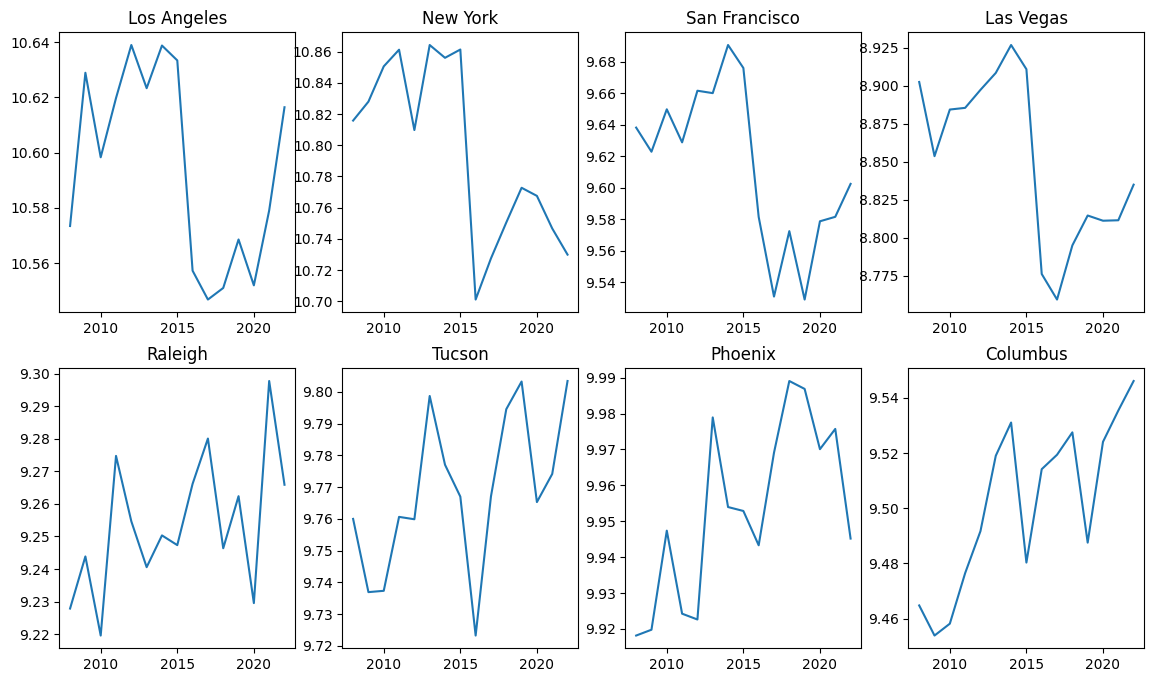

In [10]:
fig, axs = plt.subplots(2,4, figsize=(14,8))
for i, ax in enumerate(axs.flat):
    if i<len(city_list):
        city = city_list[i]
        x = df.loc[ df['city']==city, 'year']
        y = np.log(df.loc[ df['city']==city, 'building_permits'])
        ax.plot(x, y)
        ax.set_title(city)


In [11]:
df.to_csv('../data/airbnb/airbnb.csv', index=False, header=True)